In [76]:
# Usual imports
import secml
import numpy as np
from tqdm import tqdm
from scipy.special import softmax
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from joblib import Parallel, delayed
import pickle
import os
import pandas as pd
import csv

# SecML
from secml.ml.features.normalization import CNormalizerMinMax
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray
from secml.ml.classifiers import CClassifierPyTorch

# RobustBench
import robustbench
from robustbench.utils import load_model
from secml.utils import fm
from secml import settings

# Albi utils
from utils_attacks import *
from utils_CP import *

## Dataset

In [78]:
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10
lr,_ = CDataLoaderCIFAR10().load()

n_tr = 1000  # Number of training set samples
n_val = 50  # Number of validation set samples
n_ts = 5000  # Number of test set samples
n_cl = 4500 # Number of calibration set samples

n = n_tr + n_val + n_cl + n_ts

# Shuffle before splitting
random_state = 999
rng = np.random.default_rng(seed=random_state)
shuffled_indices = rng.permutation(lr.X.shape[0]).tolist()
lr = lr[shuffled_indices, :]

# Split the dataset
tr = lr[:n_tr, :]
vl = lr[n_tr:n_tr + n_val, :]
cl = lr[n_tr + n_val:n_tr + n_val + n_cl, :]
ts = lr[n_tr + n_val + n_cl:n, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
vl.X /= 255
ts.X /= 255
cl.X /= 255

In [4]:
digits = [0,1,2,3,4,5,6,7,8,9]
dataset_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Paper VRCP

### Import and train the model

In [3]:
ckptPath = ".../Your_checkpoints_path"

net = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128, 10)
)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

net = net.to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

checkpoint = torch.load(ckptPath + 'cifar10CNN.pth')

# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir(ckptPath), 'Error: no checkpoint directory found!'
checkpoint = torch.load(ckptPath + 'cifar10CNN.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#SGD
from secml.ml.classifiers import CClassifierPyTorch

optimizer = optim.SGD(net.parameters(), lr=0.001)#,
                      #momentum=0.9, weight_decay=5e-4)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

clf_VRCP = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=200,
                         batch_size=256,
                         input_shape=(3, 32, 32),
                         softmax_outputs = True,
                         random_state=0)

print("Training of classifier...")
clf_VRCP.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf_VRCP.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

==> Resuming from checkpoint..
Training of classifier...
Accuracy on test set: 79.00%


## Comparison

### Attack

In [79]:
# For VRCP comparison, eps = 0.03, steps = 100, step_size = 1/255
steps = 100
eps = 0.03 
step_size = 1/255

attack_configs = [
    {"attack_type": "PGD", "epsilon": eps, "step_size": step_size, "steps": steps, "distance": "l2", "lb": 0.0, "ub": 1.0}
]

cl_att_VRCP = attack_dataset(cl, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)
ts_att_VRCP = attack_dataset(ts, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)

Running attacks: 100%|██████████| 200/200 [00:05<00:00, 38.34sample/s]


### Compute scores

In [88]:
common_time = time.time()
cl_cs_scores_VRCP, cl_att_scores_VRCP = compute_score(cl, cl, clf_VRCP),compute_score(cl, cl_att_VRCP, clf_VRCP)
ts_cs_scores_VRCP, ts_att_scores_VRCP = compute_score(ts, ts, clf_VRCP),compute_score(ts, ts_att_VRCP, clf_VRCP)

Computing scores...: 100%|██████████| 200/200 [00:00<00:00, 380.42sample/s]


### Compute quantiles

Classic quantile: 0.8388333469629288
Attacked quantile: 0.8680884391069412


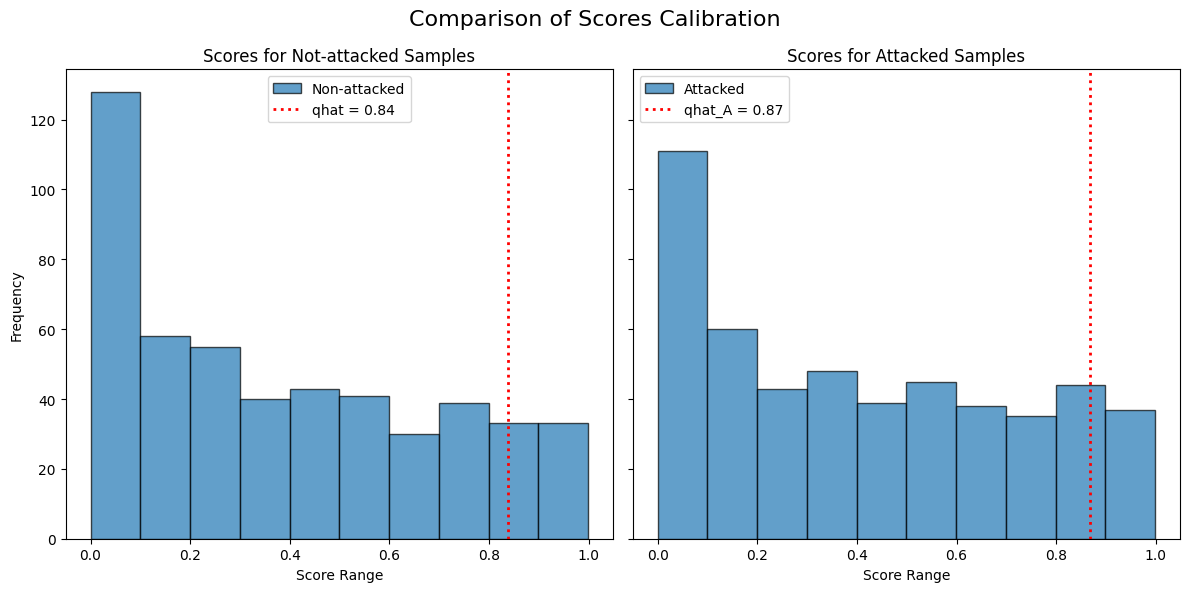

In [89]:
alpha = 0.1

q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl

qhat_VRCP = np.quantile(cl_cs_scores_VRCP, q_level, method='higher')
qhat_A_VRCP = np.quantile(cl_att_scores_VRCP, q_level, method='higher')

print('Classic quantile:', qhat_VRCP)
print('Attacked quantile:', qhat_A_VRCP)


fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].hist(cl_cs_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Non-attacked')
axs[0].axvline(x=qhat_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat = {qhat_VRCP:.2f}')
axs[0].set_title('Scores for Not-attacked Samples')
axs[0].set_xlabel('Score Range')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(cl_att_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Attacked')
axs[1].axvline(x=qhat_A_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat_A = {qhat_A_VRCP:.2f}')
axs[1].set_title('Scores for Attacked Samples')
axs[1].set_xlabel('Score Range')
axs[1].legend()

fig.suptitle(f'Comparison of Scores Calibration', fontsize=16)
plt.tight_layout()
plt.show()
end_common_time = time.time()
elapsed_common_time = end_common_time - common_time

### Vanilla CP

In [90]:
import time
start_time_vanilla = time.time()
att_conformal_sets_VRCP_vanilla, score_list = compute_CP(ts_att_VRCP, qhat_VRCP, clf_VRCP)
att_coverage_VRCP_vanilla = compute_covergae(ts, att_conformal_sets_VRCP_vanilla)

att_coverage_var_VRCP_vanilla = compute_covergae_std(ts, att_conformal_sets_VRCP_vanilla)
att_sizes_VRCP_vanilla = compute_set_sizes(ts, att_conformal_sets_VRCP_vanilla)

att_size_mean_VRCP_vanilla = mean_conformal_sets(att_conformal_sets_VRCP_vanilla)
att_size_var_VRCP_vanilla = std_conformal_sets(att_conformal_sets_VRCP_vanilla)

#plot_conformal_analysis(ts_att_VRCP, ts, att_sizes_VRCP_vanilla, cl_cs_scores_VRCP, score_list, clf_VRCP,  method = 'lac', steps = 10, dataset_name = "CIFAR10")

end_time_vanilla = time.time()
elapsed_time_vanilla = end_time_vanilla - start_time_vanilla

print(elapsed_time_vanilla + elapsed_common_time)

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [00:04<00:00, 43.13it/s]


True label is in the conformal set for 181/200 test samples (90.50%).
Coverage std (0.29).
Number of conformal sets with size 1: 105
Number of conformal sets with size 2: 74
Number of conformal sets with size 3: 21
Average set size: 1.58
Std set size: 0.6734983296193094
9.394288063049316


### PERCP 

In [91]:
import time
start_time_percp = time.time()
att_conformal_sets_VRCP,att_score_list = compute_CP(ts_att_VRCP, qhat_A_VRCP, clf_VRCP)
att_coverage_VRCP = compute_covergae(ts, att_conformal_sets_VRCP)

att_coverage_var_VRCP = round(compute_covergae_std(ts, att_conformal_sets_VRCP),2)
att_sizes_VRCP = compute_set_sizes(ts, att_conformal_sets_VRCP)

att_size_mean_VRCP = mean_conformal_sets(att_conformal_sets_VRCP)
att_size_var_VRCP = std_conformal_sets(att_conformal_sets_VRCP)

end_time_percp = time.time()
elapsed_time_percp = end_time_percp - start_time_percp

print(elapsed_time_percp + elapsed_common_time)

#plot_conformal_analysis(ts_att_VRCP, ts, att_sizes_VRCP, cl_att_scores_VRCP,att_score_list, clf_VRCP,  method = 'lac', steps = 10, dataset_name = "CIFAR10")

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [00:04<00:00, 45.36it/s]


True label is in the conformal set for 181/200 test samples (90.50%).
Coverage std (0.29).
Number of conformal sets with size 1: 92
Number of conformal sets with size 2: 73
Number of conformal sets with size 3: 32
Number of conformal sets with size 4: 3
Average set size: 1.73
Std set size: 0.7791662210337407
9.146044492721558


### Comparison Table with VRCP and RSCP

In [56]:
n_smooth = 1024 
base_path = ".../ Your_path_to_VRCP_results"

# Loop through each epsilon and read the CSV file
file_path = os.path.join(base_path, "results_CI_noisy.csv")
df = pd.read_csv(file_path)
#print(df)

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

if os.path.exists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    for method in ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]:
        # Extract the row corresponding to the method
        row = df[df['Method'] == method]

        if not row.empty:
            # Split the coverage and size columns into mean and std
            coverage = row['Coverage_CI'].values[0]
            size = row['Size_CI'].values[0]

            coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
            size_mean_val, size_std_val = map(float, size.split("±"))

            # Store the values
            coverage_mean[method].append(coverage_mean_val)
            coverage_std[method].append(coverage_std_val)
            size_mean[method].append(size_mean_val)
            size_std[method].append(size_std_val)
else:
    print(f"File not found: {file_path}")

coverage = [coverage_mean["HPS_vanilla"][0],
            coverage_mean["HPS_RSCP+"][0],
            coverage_mean["PTT_HPS_RSCP+"][0],
            coverage_mean["HPS_verif"][0],
            coverage_mean["HPS_verif_pre"][0],
            f"{att_coverage_VRCP / 100:.2f}"]

size = [size_mean["HPS_vanilla"][0],
        size_mean["HPS_RSCP+"][0],
        size_mean["PTT_HPS_RSCP+"][0],
        size_mean["HPS_verif"][0],
        size_mean["HPS_verif_pre"][0],
        att_size_mean_VRCP]

cov_std = [coverage_std["HPS_vanilla"][0],
           coverage_std["HPS_RSCP+"][0],
           coverage_std["PTT_HPS_RSCP+"][0],
           coverage_std["HPS_verif"][0],
           coverage_std["HPS_verif_pre"][0],
           att_coverage_var_VRCP] 

size_std = [size_std["HPS_vanilla"][0],
                 size_std["HPS_RSCP+"][0],
                 size_std["PTT_HPS_RSCP+"][0],
                 size_std["HPS_verif"][0],
                 size_std["HPS_verif_pre"][0],
                 att_size_var_VRCP]  # Example variances for each method

# Format the size column as "size ± variance"
coverage_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(coverage, cov_std)]

size_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(size, size_std)]
# Create DataFrame
df = pd.DataFrame({"Coverage": coverage_with_variance, "Size": size_with_variance}, index=["Vanilla", "RSCP+", "RSCP+(PTT)", "VRCP-I", "VRCP-C", "PERCP"])

# Display table
print(df)

# Save results

# Define the results folder
results_folder = "./Results"

# Ensure the folder exists
os.makedirs(results_folder, exist_ok=True)

# Define the full file path
output_file = os.path.join(results_folder, "Comparison_VRCP_CIFAR10.csv")

# Save the dataframe to CSV
df.to_csv(output_file, index=True)

print(f"File saved successfully at: {output_file}")

                 Coverage           Size
Vanilla     0.892 ± 0.011  1.751 ± 0.069
RSCP+         1.0 ± 0.000   10.0 ± 0.000
RSCP+(PTT)  0.963 ± 0.022  5.916 ± 2.223
VRCP-I      0.989 ± 0.003  4.508 ± 0.060
VRCP-C      0.997 ± 0.001  5.062 ± 0.094
PERCP        0.89 ± 0.310  1.669 ± 0.786
File saved successfully at: ./Results/Comparison_VRCP_CIFAR10.csv


### Multiple Attacks: PGD 1,10,100

In [98]:
epsilons_VRCP = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
epsilons = np.linspace(0.1,5.0,10)

extended_epsilons = epsilons_VRCP + list(epsilons)  

### Check Verifiers' and Randomizers' coverage and size curves

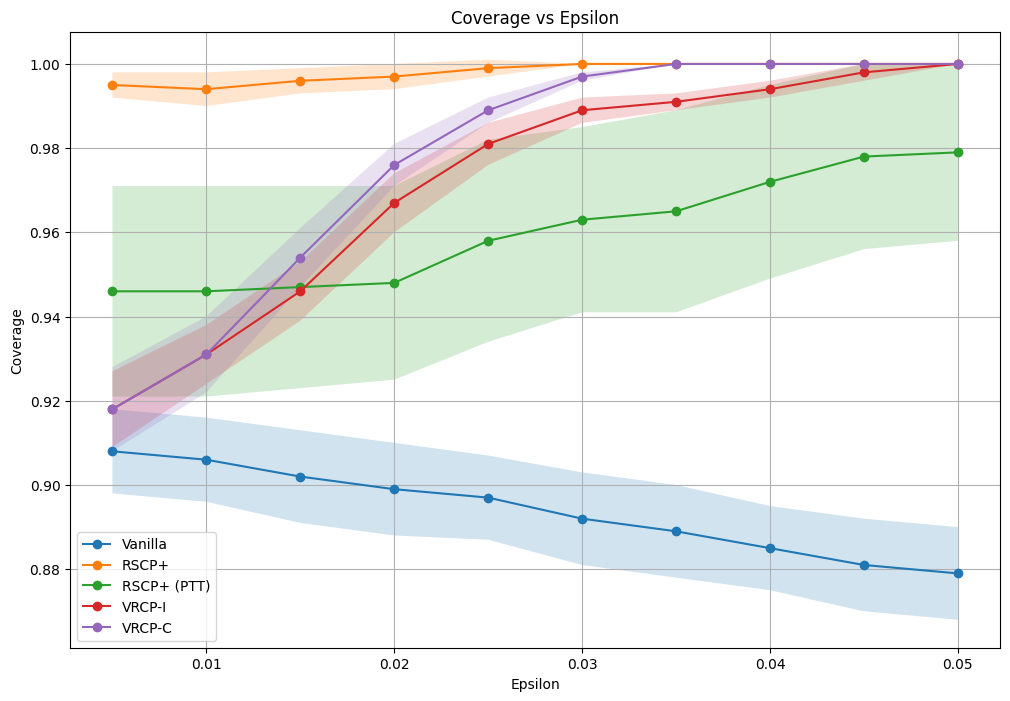

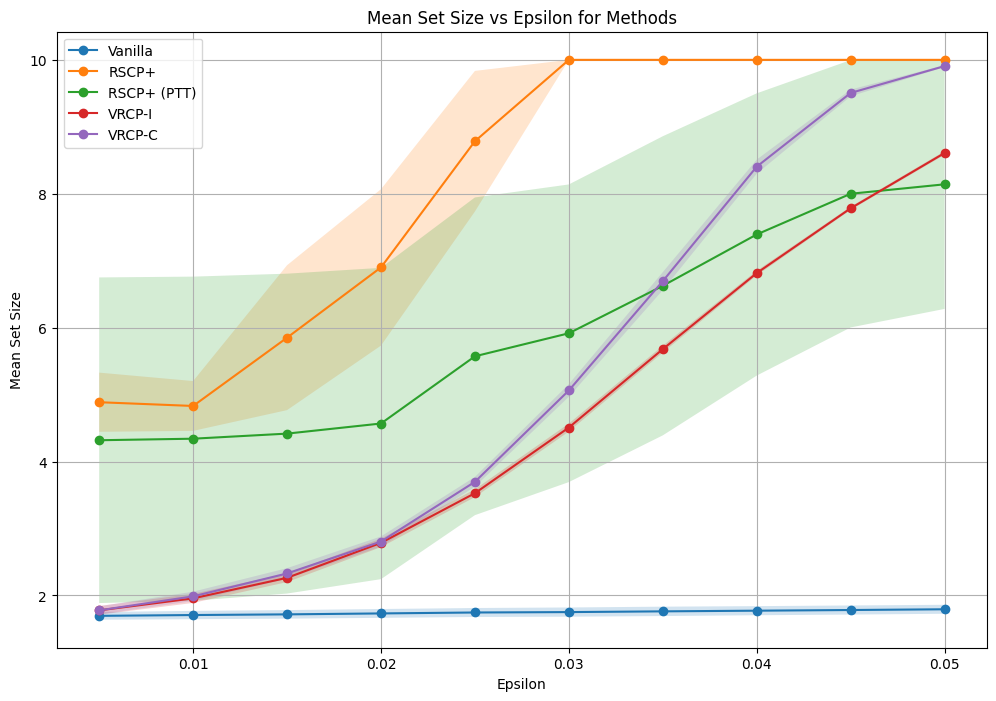

In [40]:
# Define the base path and epsilon values
base_path = "...."
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024 # 1 for linf, 1021 for l2

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

methods = ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]
label_methods = ["Vanilla", "RSCP+", "RSCP+ (PTT)","VRCP-I", "VRCP-C"]
# Loop through each epsilon and read the CSV file
for eps in epsilons_VRCP:
    file_path = os.path.join(
        base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", f"sigma_smooth_{eps*2}",
        f"n_smooth_{n_smooth}", "Robust", "CNN", "results_CI_noisy.csv"
)
            
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        for method in methods:
            # Extract the row corresponding to the method
            row = df[df['Method'] == method]
            if not row.empty:
                # Split the coverage and size columns into mean and std
                coverage = row['Coverage_CI'].values[0]
                size = row['Size_CI'].values[0]

                coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
                size_mean_val, size_std_val = map(float, size.split("±"))

                # Store the values
                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# Plot Coverage with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    
    plt.plot(epsilons_VRCP, coverage_mean[method], label=label_method, marker='o')

    plt.fill_between(epsilons_VRCP,
                     np.array(coverage_mean[method]) - np.array(coverage_std[method]),
                     np.array(coverage_mean[method]) + np.array(coverage_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Coverage")
plt.title("Coverage vs Epsilon")
plt.legend()
plt.grid(True)
plt.savefig("coverage_plot.png")
plt.show()

# Plot Size with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    plt.plot(epsilons_VRCP, size_mean[method], label=f'{label_method}', marker='o')
    plt.fill_between(epsilons_VRCP,
                     np.array(size_mean[method]) - np.array(size_std[method]),
                     np.array(size_mean[method]) + np.array(size_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Mean Set Size")
plt.title("Mean Set Size vs Epsilon for Methods")
plt.legend()
plt.grid(True)
plt.savefig("size_plot.png")
plt.show()


#### With PERCP

In [ ]:
import shutil
#extended_epsilons = epsilons_VRCP + list(epsilons)
# Define the attack configs
alpha = 0.1
model_name = "VRCP"
norm_name = "l2"


attack_configs = [
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 1, "distance": "l2", "lb": 0.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 10, "distance": "l2", "lb": 0.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 100, "distance": "l2", "lb": 0.0, "ub": 1.0}

]

# Define the base output directory
base_output_dir = "./Results_6/" + model_name

# Clear previous results before starting a new attack configuration list
if os.path.exists(base_output_dir):
    shutil.rmtree(base_output_dir)  # Deletes the entire directory
os.makedirs(base_output_dir, exist_ok=True)  # Recreate empty directory

for eps in tqdm(extended_epsilons, desc="epsilon", leave = True):
    
    new_configs = []
    for attack in attack_configs:
        steps = attack["steps"]
        new_attack = attack.copy()
        if "epsilon" in new_attack:
            new_attack["epsilon"] = eps
        if "step_size" in new_attack:
            new_attack["step_size"] = eps/steps
        new_configs.append(new_attack)
    
    save_path = os.path.join(base_output_dir, norm_name, f"eps_{eps:.4f}")
    os.makedirs(save_path, exist_ok=True)

    # Define the CSV file path
    csv_file = os.path.join(save_path, "results.csv")

    cl_att_dict = attack_dataset(cl, clf_VRCP, new_configs, desc="Running attacks", n_jobs=1)
    ts_att_dict = attack_dataset(ts, clf_VRCP, new_configs, desc="Running attacks", n_jobs=1)

    if isinstance(cl_att_dict,dict):
        
        for attack_type in cl_att_dict.keys():

            cl_att = cl_att_dict[attack_type]
            ts_att = ts_att_dict[attack_type]

            cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

            # Get quantile
            q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
            qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

            # Conformal sets
            att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
            # Compute coverage and variance
            att_coverage = compute_covergae(ts, att_conformal_sets)
            att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

            # Compute mean and variance of set sizes
            att_size_mean = mean_conformal_sets(att_conformal_sets)
            att_size_var = std_conformal_sets(att_conformal_sets) / 10
            
            # Store results
            results = [
                {  
                    "attack_type": f"{attack_type}",
                    "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                    "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
                }
            ]

            # Save results to CSV 
            file_exists = os.path.isfile(csv_file)
            with open(csv_file, mode="a", newline="") as file:
                writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
                if not file_exists:
                    writer.writeheader()  # Write header only if the file is new
                writer.writerows(results)

            print(f"Results saved to {csv_file}")
    else:
        
        attack_type = get_single_attack_key(new_configs[0])

        cl_att = cl_att_dict
        ts_att = ts_att_dict

        cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

        # Get quantile
        q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
        qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

        # Conformal sets
        att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
        # Compute coverage and variance
        att_coverage = compute_covergae(ts, att_conformal_sets)
        att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

        # Compute mean and variance of set sizes
        att_size_mean = mean_conformal_sets(att_conformal_sets)
        att_size_var = std_conformal_sets(att_conformal_sets) / 10


        # Store results
        results = [
            {  
                "attack_type": f"{attack_type}",
                "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
            }
        ]

        # Save results to CSV 
        file_exists = os.path.isfile(csv_file)
        with open(csv_file, mode="a", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
            if not file_exists:
                writer.writeheader()  # Write header only if the file is new
            writer.writerows(results)

        print(f"Results saved to {csv_file}")


Running attacks:  44%|████▍     | 220/500 [05:07<06:17,  1.35s/sample]


Running attacks:  88%|████████▊ | 440/500 [10:28<01:29,  1.49s/sample]


Running attacks: 100%|██████████| 500/500 [11:56<00:00,  1.43s/sample]

Running attacks:  80%|████████  | 161/200 [03:54<00:56,  1.44s/sample]


Running attacks: 100%|██████████| 200/200 [04:51<00:00,  1.46s/sample]

Computing scores...: 100%|██████████| 500/500 [00:01<00:00, 323.99sample/s]

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [00:05<00:00, 38.25it/s]


True label is in the conformal set for 183/200 test samples (91.50%).
Coverage std (0.28).
Average set size: 2.365
Std set size: 1.1965680089322126
Results saved to ./Results_6/VRCP/l2/eps_0.1000/results.csv



Computing scores...: 100%|██████████| 500/500 [00:01<00:00, 326.35sample/s]

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [00:05<00:00, 39.20it/s]


True label is in the conformal set for 182/200 test samples (91.00%).
Coverage std (0.29).
Average set size: 2.3
Std set size: 1.1874342087037917
Results saved to ./Results_6/VRCP/l2/eps_0.1000/results.csv



Computing scores...: 100%|██████████| 500/500 [00:01<00:00, 315.37sample/s]

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [00:05<00:00, 39.42it/s]


True label is in the conformal set for 183/200 test samples (91.50%).
Coverage std (0.28).
Average set size: 2.355
Std set size: 1.1870025273772586
Results saved to ./Results_6/VRCP/l2/eps_0.1000/results.csv



Computing scores...: 100%|██████████| 500/500 [00:01<00:00, 331.77sample/s]

epsilon:   2%|▏         | 1/50 [17:15<14:05:27, 1035.24s/it]

True label is in the conformal set for 183/200 test samples (91.50%).
Coverage std (0.28).
Average set size: 2.365
Std set size: 1.1965680089322126
Results saved to ./Results_6/VRCP/l2/eps_0.1000/results.csv



Running attacks:  25%|██▍       | 123/500 [03:02<09:23,  1.49s/sample]

### Plots

In [99]:
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR10/Results/VRCP/l2"

results_dict = {}

for eps in extended_epsilons:

    file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  

    if  os.path.isfile(file_path):
        file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  
    #else:
    #    file_path = os.path.join(base_path_VRCP_eps, f"eps_{eps:.4f}", "results.csv") 

    config_results_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip the header or any empty lines
            if line.lower().startswith("attack_type"):
                continue

            # Split each line into columns based on commas
            cols = line.strip().split(',')

            if len(cols) >= 3:
                attack_type = cols[0].strip()
                coverage = cols[1].strip()
                size = cols[2].strip()

                # Extract mean and std values for coverage and size
                coverage_mean, coverage_std = map(float, coverage.split("±"))
                size_mean, size_std = map(float, size.split("±"))


            # Store the results in the dictionary
                config_results_dict[attack_type] = {
                    "coverage_mean": coverage_mean,
                    "coverage_std": coverage_std,
                    "size_mean": size_mean,
                    "size_std": size_std,
                }

            else:
                print(f"File not found: {file_path}")

        results_dict[f"{eps:.4f}"] = config_results_dict
        
print("Data loaded in the dictionary.")
print(" ")
print("The following attacks are available")
print(" ")
attack_names = list(next(iter(results_dict.values())).keys())
print(attack_names)

File not found: /home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR10/Results/VRCP/l2/eps_0.0050/results.csv
Data loaded in the dictionary.
 
The following attacks are available
 
['combined', 'PGD_1_l2', 'PGD_10_l2', 'PGD_100_l2']


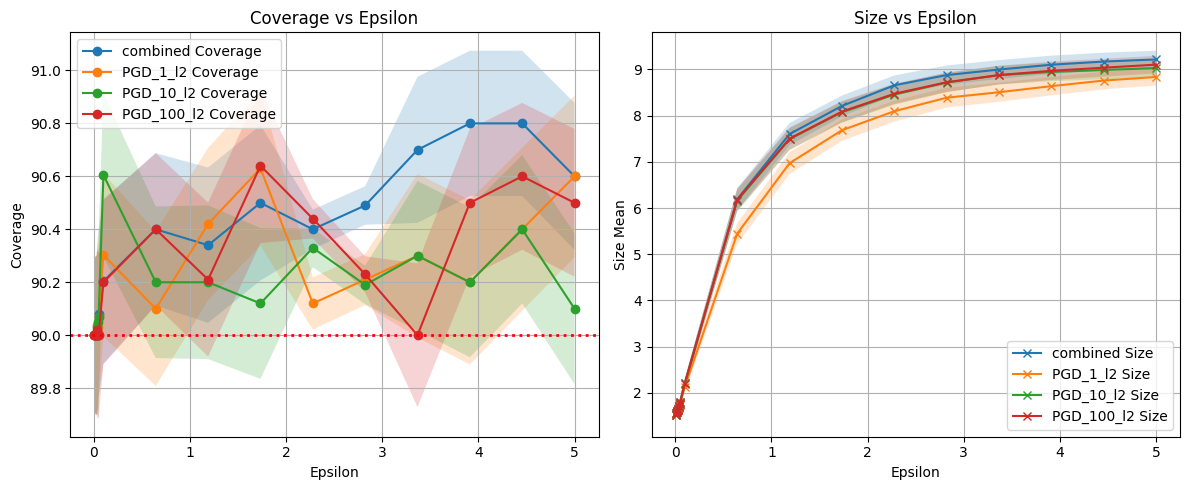

In [100]:

# Define figure
plt.figure(figsize=(12, 5))

# Set reference value for 1 - alpha
one_minus_alpha_ref = (1 - alpha) * 100  # Convert to percentage

for attack_name in attack_names:

    # Extract coverage and size mean/std for each epsilon
    coverage = [results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] for eps in extended_epsilons]
    size = [results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons]

    coverage_std = [results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] for eps in extended_epsilons]
    size_std = [results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons]

    # Convert to NumPy arrays for plotting
    epsilons_np = np.array(extended_epsilons)
    coverage_np, coverage_std_np = np.array(coverage), np.array(coverage_std)
    size_np, size_std_np = np.array(size), np.array(size_std)

    # Plot Coverage vs Epsilon
    plt.subplot(1, 2, 1)
    plt.plot(epsilons_np, coverage_np, label=f'{attack_name} Coverage', marker='o')  # Convert coverage to percentage
    plt.fill_between(epsilons_np, (coverage_np - coverage_std_np), (coverage_np + coverage_std_np), alpha=0.2)

    # Plot Size vs Epsilon
    plt.subplot(1, 2, 2)
    plt.plot(epsilons_np, size_np, label=f'{attack_name} Size', marker='x')
    plt.fill_between(epsilons_np, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

# Add horizontal red line at (1 - α) * 100 on the coverage plot
plt.subplot(1, 2, 1)
plt.axhline(y=one_minus_alpha_ref, color='r', linestyle='dotted', linewidth=2)

# Add label on the y-axis at (1 - α) * 100
plt.subplot(1, 2, 1)
plt.ylabel('Coverage')  # Base y-axis label
#plt.text(x=epsilons_np[0] - (epsilons_np[-1] - epsilons_np[0]) * 0.1,  # Shift left of y-axis
#         y=one_minus_alpha_ref, 
#         s=f'{one_minus_alpha_ref:.1f}', 
#         color='r', fontsize=10, verticalalignment='center', horizontalalignment='right')

# Customize plot appearance
plt.subplot(1, 2, 1)
plt.xlabel('Epsilon')
plt.title('Coverage vs Epsilon')
plt.legend()
#plt.ylim(0.0, 100.0)  # Ensure it's between 0 and 100
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlabel('Epsilon')
plt.ylabel('Size Mean')
plt.title('Size vs Epsilon')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save and show the plot
plt.savefig('coverage_size_plot.png', dpi=300)
plt.show()
